In [451]:
import numpy as np
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [460]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.size'] = 18
font = {'size'   : 18}
matplotlib.rc('font', **font)

In [453]:
# Load data inputs used in optimization model

generators = pd.read_csv("Data/GeneratorsNetwork.csv")
storage_elec = pd.read_csv("Data/Storage_ELECNetwork.csv")
storage_gas = pd.read_csv("Data/Storage_GASNetwork.csv")
p2g = pd.read_csv("Data/PowerToGasNetwork.csv")
appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")

GEN = len(generators)
STORAGE_ELEC = len(storage_elec)
STORAGE_GAS = len(storage_gas)
P2G = len(p2g)

resource_list = np.append(np.append(np.append(generators["Prime Mover"].to_numpy(), storage_elec["Prime Mover"].to_numpy()), p2g["Prime Mover"].to_numpy()), storage_gas["Prime Mover"].to_numpy())
resource_list = np.where(resource_list == "Net-zero CH4", "Electro-methane",resource_list)
resource_list_GEN = (generators["Prime Mover"].to_numpy())
resource_list_P2G = (p2g["Prime Mover"].to_numpy())
resource_list_P2G = np.where(resource_list_P2G == "Net-zero CH4", "Electro-methane",resource_list_P2G)

unique_resources = np.append(np.append(np.append(generators["Prime Mover"].drop_duplicates().to_numpy(), storage_elec["Prime Mover"].drop_duplicates().to_numpy()), p2g["Prime Mover"].drop_duplicates().to_numpy()), storage_gas["Prime Mover"].drop_duplicates().to_numpy())
unique_resources_GEN = generators["Prime Mover"].drop_duplicates().to_numpy()
unique_resources_STORAGE = np.append(storage_elec["Prime Mover"].drop_duplicates().to_numpy(), storage_gas["Prime Mover"].drop_duplicates().to_numpy())
unique_resources_P2G = p2g["Prime Mover"].drop_duplicates().to_numpy()
unique_resources_P2G = np.where(unique_resources_P2G == "Net-zero CH4", "Electro-methane",unique_resources_P2G)

locational_resources = np.append(np.append(np.append(generators["Node_ELEC"].to_numpy(), storage_elec["Node_ELEC"].to_numpy()), p2g["Node_ELEC"].to_numpy()), storage_gas["Node_ELEC"].to_numpy())
locational_resources_GEN = generators["Node_ELEC"].to_numpy()

colors = np.array(["black","dimgray","darkgray","gainsboro","yellowgreen","olive","orange","gold","yellow","darkturquoise","mediumslateblue","rebeccapurple","darkred","deepskyblue","teal",
    "lightcoral","lemonchiffon","darkgreen","limegreen","forestgreen","rosybrown"])

colors_GEN = np.array(["black","dimgray","darkgray","gainsboro","yellowgreen","olive","orange","gold","yellow","darkturquoise","mediumslateblue","rebeccapurple","darkred","deepskyblue","teal"])
colors_STORAGE = np.array(["lightcoral","lemonchiffon","rosybrown"])
colors_P2G = np.array(["darkgreen","limegreen","forestgreen"])

appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")
appliances_gascons = pd.read_csv("Data/ApplianceProfiles_GASNetworkCold.csv")
appliances_eleccons = pd.read_csv("Data/ApplianceProfiles_ELECNetworkCold.csv")
unique_appliancetypes =  appliances["Appliance Name"].drop_duplicates().to_numpy()
appliances_list = appliances["Appliance Name"].to_numpy()
locational_resources_appliances = appliances["Node_ELEC"].to_numpy()


In [528]:
print(len(colors))
print(len(unique_resources))
# print(unique_resources_GEN)
# print(unique_resources_P2G)
# print(unique_resources_STORAGE)
# print(colors)
# print(unique_resources)


caseNum = 1
date_stamps = ["20230919-164922"] # 20230911-182951 unlimited electricity flow, 20230911-191056 constrained
                                  # 20230912-033348 cost, 20230912-042824 reduce 35%
                                  # 164922 base, 165420 no transmission exp., 165810 unlimited no cost exp
                                  # 170419 10% offset, 170958 20% offset
                                  # 171307 20% h2, 172104 offset + no expansion + h2 blend
case_studies = ["Base Case"]
case_names = ["Base Case"]

case1 = case_names[caseNum-1]
date_stamp1 = date_stamps[caseNum-1]
case_study = case_studies[caseNum-1]

folder1 = "Output/%s" % date_stamp1
folder = folder1

system = "Network"
region = "Cold"
num = ""

biomethane = "Mid"
industrials = "None"
buildingretrofits = "Low"
GasQuality = "Nodal" # "Annual", "No"

case = "WithAppDecisions"
offsets_case = "UnlimitedOffsets"
retirements_case = "NoGasDistRet"

CleanElecCosts = "Mid"
CleanGasCosts = "Mid"
NETSCost = "Mid"

T_inv = 5
Years = np.array([2025,2030,2035,2040,2045])

21
21


## Gas and Electric Capacity Expansion and Annual Generation

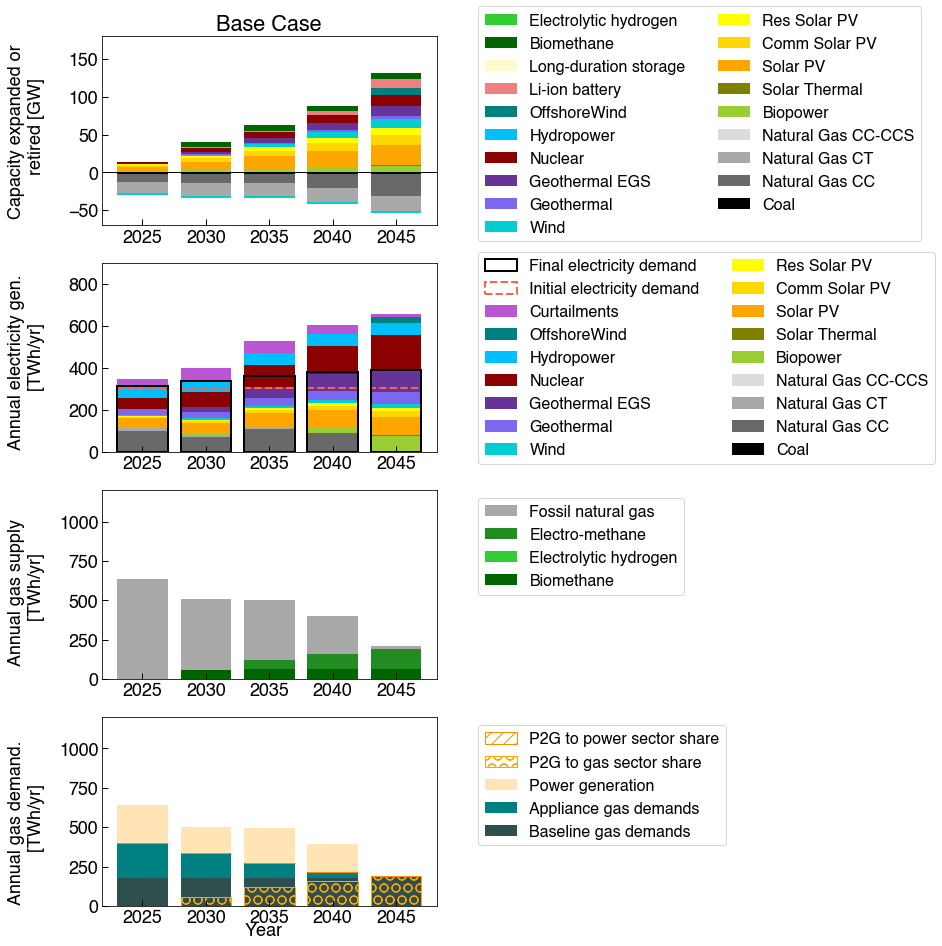

In [529]:
xy = 0
fig, axes = plt.subplots(4, 1, figsize = (6,16))
appliance_cases = np.array([case1])

for i in range(len(appliance_cases)):
    folder = folder1

    # Total capacity built and retired
    resources = np.zeros((len(unique_resources),T_inv))
    resources_minus = np.zeros((len(unique_resources),T_inv))
    data = pd.read_csv(f"%s/CAPACITY_BUILT.csv" % folder).to_numpy()
    data = data[0:-1,:]
    data_retired = pd.read_csv(f"%s/CAPACITY_RETIRED.csv" % folder).to_numpy()
    data2X = pd.read_csv(f"%s/HOURLY_LOAD.csv" % folder).to_numpy()
    data_retired = data_retired[0:-1,:]
    stack = np.zeros((T_inv))
    stack_minus = stack.copy()
    for k in range(len(unique_resources)):
        for j in range(T_inv):
            for jj in range(j+1):
                resources_minus[k,j] = resources_minus[k,j]+np.sum(data_retired[resource_list == unique_resources[k],jj],0)
                resources[k,j] = resources[k,j]+np.sum(data[resource_list == unique_resources[k],jj],0)

        if sum(resources[k,:]) > 0:
            axes[0].bar(Years, resources[k,:]/10**3, label = unique_resources[k], bottom = stack, width = 4, align = "center", color = colors[k])
            stack = stack + resources[k,:]/10**3
        if sum(resources_minus[k,:]) > 0:
            if sum(resources[k,:]) > 0:
                axes[0].bar(Years, -1*resources_minus[k,:]/10**3, bottom = stack_minus, width = 4, align = "center", color = colors[k])
            if sum(resources[k,:]) <= 0:
                axes[0].bar(Years, -1*resources_minus[k,:]/10**3, label = unique_resources[k], bottom = stack_minus, width = 4, align = "center", color = colors[k])
            stack_minus = stack_minus - resources_minus[k,:]/10**3
    
    data = pd.read_csv(f"%s/GENERATION.csv" % folder).to_numpy()

    data_elec = data[GEN+P2G:GEN+P2G+8,:].copy()
    data = data[0:GEN,:].copy()
    stack = np.zeros((T_inv))
    for k in range(len(unique_resources_GEN)):
        resources = np.sum(data[resource_list_GEN == unique_resources_GEN[k],:],0)
        axes[1].bar(Years, resources/10**6, label = unique_resources_GEN[k],color = colors_GEN[k], bottom = stack, width = 4, align = "center")
        stack = stack + resources/10**6
    resources = data_elec[7,:].copy()
    axes[1].bar(Years, resources/10**6, label = "Curtailments", color = "mediumorchid", linewidth = 2, ls = "--", bottom = stack, width = 4, align = "center")
    electricity_stack = stack
    
    resources = np.ones([1,5]) * data_elec[4,0].copy()
    stack = np.zeros((T_inv))
    axes[1].bar(Years, resources[0]/10**6, label = "Initial electricity demand", color = "none", alpha = 1, edgecolor = 'tomato', linewidth = 2, ls = "--", bottom = stack, width = 4, align = "center")
    resources = data_elec[5,:].copy()
    stack = np.zeros((T_inv))
    axes[1].bar(Years, resources/10**6, label = "Final electricity demand", color = "none", alpha = 1, edgecolor = 'k', linewidth = 2, bottom = stack, width = 4, align = "center")

    #############################
    ## Total annual gas generation
    data = pd.read_csv(f"%s/GENERATION.csv" % folder).to_numpy()
    data_gas = data[GEN+P2G:GEN+P2G+9,:]
    data = data[GEN:GEN+P2G,:]
    stack = np.zeros((T_inv))
    for k in range(len(unique_resources_P2G)):
        resources = np.sum(data[resource_list_P2G == unique_resources_P2G[k],:],0)
        axes[2].bar(Years, resources/10**6, label = unique_resources_P2G[k],color = colors_P2G[k], bottom = stack, width = 4, align = "center")
        stack = stack + resources/10**6
        
    axes[2].bar(Years, np.maximum(data_gas[6,:].copy()/10**6,0), label = "Fossil natural gas", color = "darkgrey", bottom = stack, width = 4, align = "center")

    #############################
    ## Total annual gas demand

    data_baselinegas = np.sum(data2X[3,int((0)*24):int((365)*24)]) #kWh baseline gas consumption/yr

    # stack = np.zeros((T_inv))
    # axes[3].bar(Years, np.maximum((data_gas[6,:].copy()+np.sum(data[:,:],0))/10**6,0), color = "lightgrey", bottom = stack, width = 4, align = "center")
    stack = np.zeros((T_inv))
    resources_bg = np.ones([5]) * data_baselinegas/10**6
    axes[3].bar(Years, resources_bg, label = "Baseline gas demands", color = "darkslategray", alpha = 1, bottom = stack, width = 4, align = "center")
    resources = data_gas[1,:].copy()/10**6 - resources_bg
    axes[3].bar(Years, resources, label = "Appliance gas demands", color = "teal", alpha = 1, bottom = resources_bg, width = 4, align = "center")
    axes[3].bar(Years, np.maximum((data_gas[8,:].copy())/10**6,0), label = "Power generation",color = "moccasin", alpha = 1, bottom = resources_bg+resources, width = 4, align = "center")

    stack = np.zeros((T_inv))
    resources3 = data_gas[3,:].copy()
    axes[3].bar(Years, resources3/10**6, label = "P2G to gas sector share", color = "none", alpha = 1, hatch='O', edgecolor = 'orange',linewidth = 1, bottom = stack, width = 4, align = "center")
    
    resources2 = data_gas[2,:].copy()
    axes[3].bar(Years, resources2/10**6, label = "P2G to power sector share", color = "none", alpha = 1, hatch='//', linewidth = 1,edgecolor = 'darkorange', bottom = resources_bg+resources, width = 4, align = "center")


    for ii in range(4):
        axes[ii].axhline(linewidth=1, color='k')
        axes[ii].tick_params(direction='in', length=6, width=1, colors='k')

handles, labels = axes[0].get_legend_handles_labels()
labels = np.where(np.array(labels) == "Electrolysis","Electrolytic hydrogen",np.array(labels))
axes[0].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.2), loc='upper left', prop={'size': 16},ncol=2)
handles, labels = axes[1].get_legend_handles_labels()
labels = np.where(np.array(labels) == "Electrolysis","Electrolytic hydrogen",np.array(labels))
axes[1].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.1), loc='upper left', prop={'size': 16},ncol=2)
handles, labels = axes[2].get_legend_handles_labels()
labels = np.where(np.array(labels) == "Electrolysis","Electrolytic hydrogen",np.array(labels))
axes[2].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1), loc='upper left',prop={'size': 16})
handles, labels = axes[3].get_legend_handles_labels()
axes[3].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1), loc='upper left',prop={'size': 16})

fig.text(-0.05, 0.8, 'Capacity expanded or \n retired [GW]', ha='center', va='center', rotation='vertical')
fig.text(-0.05, 0.6, 'Annual electricity gen. \n [TWh/yr]', ha='center', va='center', rotation='vertical')
fig.text(-0.05, 0.4, 'Annual gas supply \n [TWh/yr]', ha='center', va='center', rotation='vertical')
fig.text(-0.05, 0.2, 'Annual gas demand. \n [TWh/yr]', ha='center', va='center', rotation='vertical')

axes[0].set_ylim([-70,180])
axes[1].set_ylim([0,900])
axes[2].set_ylim([0,1200])
axes[3].set_ylim([0,1200])
axes[0].set_title(case1)

fig.text(0.5, 0.1, 'Year', ha='center')
# fig.suptitle(f"Appliance optimization scenarios")
# fig.savefig(f"Plots/{case_study}/Investment_Period_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()


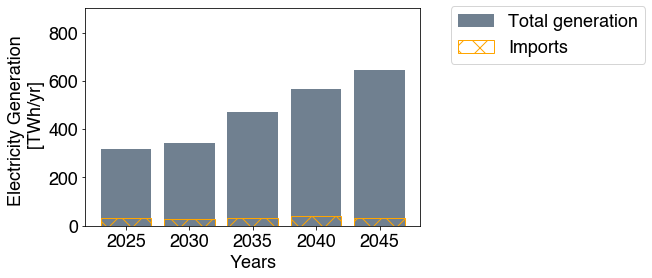

In [530]:
data = pd.read_csv(f"%s/GENERATION.csv" % folder).to_numpy()

imports = data[227-1:238-1,:].copy()


plt.bar(Years, electricity_stack,width = 4,label='Total generation',color ='slategray')
plt.bar(Years, np.sum(imports,0)/10**6,width = 4,color = "none", alpha = 1, hatch='x', edgecolor = 'orange',linewidth = 1,label='Imports')
plt.xlabel('Years')
plt.ylabel('Electricity Generation \n [TWh/yr]')
plt.legend(bbox_to_anchor=(1.7, 1.05))
plt.ylim([0,900])
# fig.savefig(f"Plots/{case_study}/Generation_Imports_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()

## End-Use Appliance Decisions

<ipython-input-531-bcb317354f87>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels)
<ipython-input-531-bcb317354f87>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels)


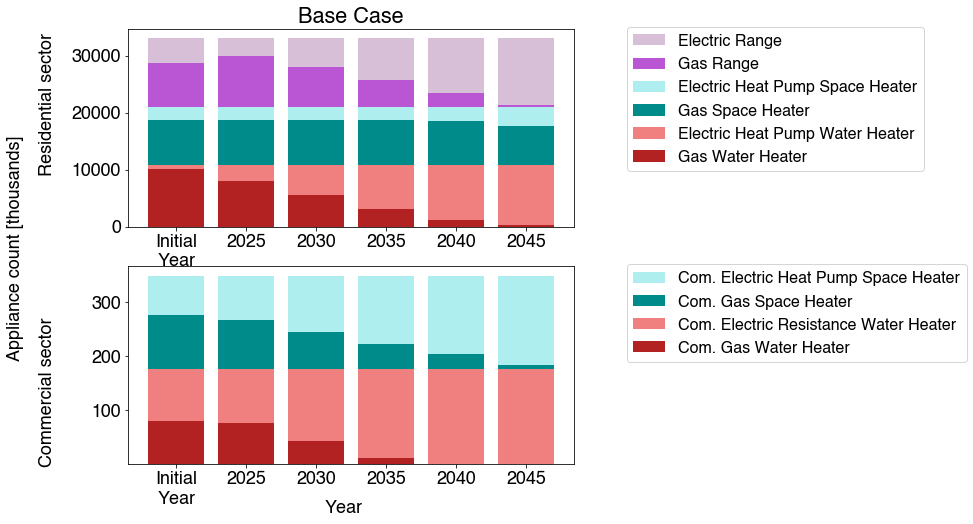

In [531]:
unique_appliancetypes_RES = unique_appliancetypes[0:6]
unique_appliancetypes_COMM = unique_appliancetypes[6:10]

appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")
initial_pop = appliances["Appliance Count [no.]"]/1000
NewYears = np.array([2020,2025,2030,2035,2040,2045])

appliance_labels = ["Gas Water Heater","Electric Heat Pump Water Heater","Gas Space Heater","Electric Heat Pump Space Heater","Gas Range","Electric Range"]
appliance_labels_COMM = ["Com. Gas Water Heater","Com. Electric Resistance Water Heater","Com. Gas Space Heater","Com. Electric Heat Pump Space Heater"]
fig, axes = plt.subplots(2, 1, figsize = (8,8), sharex = False, sharey = False)

colors_ResApps = ["firebrick","lightcoral","darkcyan","paleturquoise","mediumorchid","thistle"]
colors_CommApps = ["firebrick","lightcoral","darkcyan","paleturquoise"]

for i in range(len(appliance_cases)):
    folder = folder1
    resources = np.zeros((len(unique_appliancetypes),1))
    data = pd.read_csv(f"%s/APPLIANCE_DECISIONS.csv" % folder).to_numpy()
    newbuild = np.zeros((len(data[:,0]),T_inv))
    premature = np.zeros((len(data[:,0]),T_inv))
    totalpop = np.zeros((len(data[:,0]),T_inv))
    for k in range(T_inv):
        newbuild[:,k] = data[:,k*3]
        premature[:,k] = data[:,k*3+1]
        totalpop[:,k] = data[:,k*3+2]
    newtotalpop = np.zeros((len(data[:,0]),T_inv+1))
    newtotalpop[:,0] = initial_pop
    newtotalpop[:,1:6] = totalpop
    
    stack = np.zeros((T_inv+1))
    for k in range(len(unique_appliancetypes_RES)):
        resources = np.sum(newtotalpop[appliances_list == unique_appliancetypes_RES[k],:],0)
        axes[0].bar(NewYears, resources,color = colors_ResApps[k],label = appliance_labels[k], bottom = stack, width = 4, align = "center")
            
        stack = stack + resources

    stack = np.zeros((T_inv+1))
    for k in range(len(unique_appliancetypes_COMM)):
        resources = np.sum(newtotalpop[appliances_list == unique_appliancetypes_COMM[k],:],0)
        axes[1].bar(NewYears, resources,color = colors_CommApps[k],label = appliance_labels_COMM[k], bottom = stack, width = 4, align = "center")

        stack = stack + resources

        
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.05), loc='upper left', prop={'size': 16})        
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.05), loc='upper left', prop={'size': 16})

fig.text(-0.07, 0.5, 'Appliance count [thousands]', ha='center', va='center', rotation='vertical')
axes[0].set_title(case1)
fig.text(0.5, 0.04, 'Year', ha='center')
fig.text(-0.015, 0.75, 'Residential sector', ha='center', va='center', rotation='vertical')
fig.text(-0.015, 0.25, 'Commercial sector', ha='center', va='center', rotation='vertical')

labels = [0,"Initial\nYear",2025,2030,2035,2040,2045]
axes[0].set_xticklabels(labels)
axes[1].set_xticklabels(labels)

# fig.savefig(f"Plots/{case_study}/Appliances_Decisions_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()



<ipython-input-457-40a4ae5e29c7>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels)
<ipython-input-457-40a4ae5e29c7>:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels)


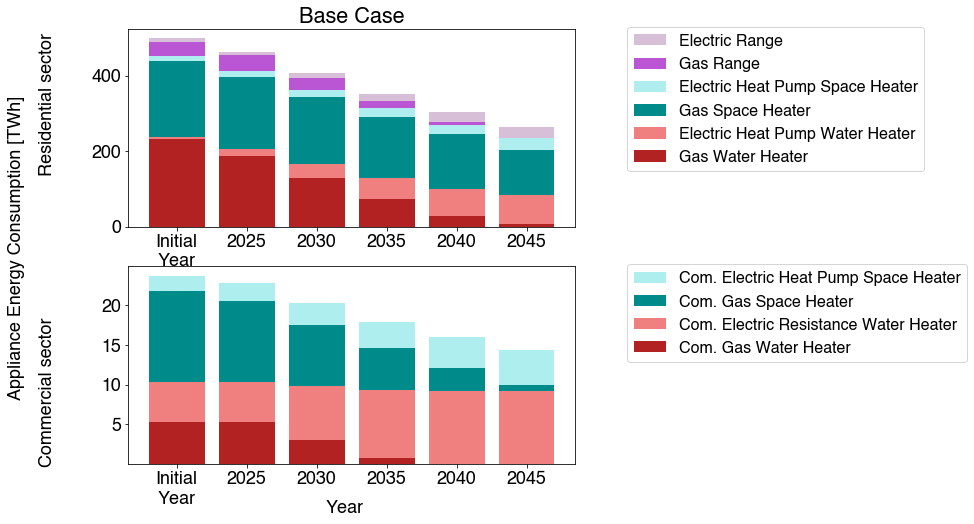

In [457]:
unique_appliancetypes_RES = unique_appliancetypes[0:6]
unique_appliancetypes_COMM = unique_appliancetypes[6:10]

appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")
initial_pop = appliances["Appliance Count [no.]"]/1000
NewYears = np.array([2020,2025,2030,2035,2040,2045])

consumption_elec = np.sum(pd.read_csv("Data/ApplianceProfiles_ELECNetworkCold.csv"), axis=0) # MWh read in
consumption_gas = np.sum(pd.read_csv("Data/ApplianceProfiles_GASNetworkCold.csv"), axis=0)
total_con = consumption_gas+consumption_elec
total_con_reindexed = initial_pop.copy()
total_con_reindexed.values[:] = total_con.values

appliance_labels = ["Gas Water Heater","Electric Heat Pump Water Heater","Gas Space Heater","Electric Heat Pump Space Heater","Gas Range","Electric Range"]
appliance_labels_COMM = ["Com. Gas Water Heater","Com. Electric Resistance Water Heater","Com. Gas Space Heater","Com. Electric Heat Pump Space Heater"]
fig, axes = plt.subplots(2, 1, figsize = (8,8), sharex = False, sharey = False)

colors_ResApps = ["firebrick","lightcoral","darkcyan","paleturquoise","mediumorchid","thistle"]
colors_CommApps = ["firebrick","lightcoral","darkcyan","paleturquoise"]

for i in range(len(appliance_cases)):
    folder = folder1
    resources = np.zeros((len(unique_appliancetypes),1))
    data = pd.read_csv(f"%s/APPLIANCE_DECISIONS.csv" % folder).to_numpy()
    newbuild = np.zeros((len(data[:,0]),T_inv))
    premature = np.zeros((len(data[:,0]),T_inv))
    totalpop = np.zeros((len(data[:,0]),T_inv))
    for k in range(T_inv):
        newbuild[:,k] = data[:,k*3]
        premature[:,k] = data[:,k*3+1]
        totalpop[:,k] = data[:,k*3+2]
    newtotalpop = np.zeros((len(data[:,0]),T_inv+1))
    newtotalpop[:,0] = initial_pop * total_con_reindexed
    for m in range(5):
        newtotalpop[:,m+1] = totalpop[:,m] * total_con_reindexed
    
    stack = np.zeros((T_inv+1))
    for k in range(len(unique_appliancetypes_RES)):
        resources = np.sum(newtotalpop[appliances_list == unique_appliancetypes_RES[k],:],0)/1000 # convert to TWh
        axes[0].bar(NewYears, resources,color = colors_ResApps[k],label = appliance_labels[k], bottom = stack, width = 4, align = "center")
            
        stack = stack + resources

    stack = np.zeros((T_inv+1))
    for k in range(len(unique_appliancetypes_COMM)):
        resources = np.sum(newtotalpop[appliances_list == unique_appliancetypes_COMM[k],:],0)/1000 # convert to TWh
        axes[1].bar(NewYears, resources,color = colors_CommApps[k],label = appliance_labels_COMM[k], bottom = stack, width = 4, align = "center")

        stack = stack + resources

        
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.05), loc='upper left', prop={'size': 16})        
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.05), loc='upper left', prop={'size': 16})

fig.text(-0.07, 0.5, 'Appliance Energy Consumption [TWh]', ha='center', va='center', rotation='vertical')
axes[0].set_title(case1)
fig.text(0.5, 0.04, 'Year', ha='center')
fig.text(-0.015, 0.75, 'Residential sector', ha='center', va='center', rotation='vertical')
fig.text(-0.015, 0.25, 'Commercial sector', ha='center', va='center', rotation='vertical')

labels = [0,"Initial\nYear",2025,2030,2035,2040,2045]
axes[0].set_xticklabels(labels)
axes[1].set_xticklabels(labels)

# fig.savefig(f"Plots/{case_study}/Appliances_Decisions_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()



## Representative Days Heatmap

In [329]:
DAYS = ['Sun.', 'Mon.', 'Tues.', 'Wed.', 'Thurs.', 'Fri.', 'Sat.']
MONTHS = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']


def date_heatmap(series, start=None, end=None, mean=False, ax=None, **kwargs):
    '''Plot a calendar heatmap given a datetime series.

    Arguments:
        series (pd.Series):
            A series of numeric values with a datetime index. Values occurring
            on the same day are combined by sum.
        start (Any):
            The first day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            earliest date in the data.
        end (Any):
            The last day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            latest date in the data.
        mean (bool):
            Combine values occurring on the same day by mean instead of sum.
        ax (matplotlib.Axes or None):
            The axes on which to draw the heatmap. The default is the current
            axes in the :module:`~matplotlib.pyplot` API.
        **kwargs:
            Forwarded to :meth:`~matplotlib.Axes.pcolormesh` for drawing the
            heatmap.

    Returns:
        matplotlib.collections.Axes:
            The axes on which the heatmap was drawn. This is set as the current
            axes in the `~matplotlib.pyplot` API.
    '''
    # Combine values occurring on the same day.
    dates = series.index.floor('D')
    group = series.groupby(dates)
    series = group.mean() if mean else group.sum()

    # Parse start/end, defaulting to the min/max of the index.
    start = pd.to_datetime(start or series.index.min())
    end = pd.to_datetime(end or series.index.max())

    # We use [start, end) as a half-open interval below.
    end += np.timedelta64(1, 'D')

    # Get the previous/following Sunday to start/end.
    # Pandas and numpy day-of-week conventions are Monday=0 and Sunday=6.
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun = end + np.timedelta64(7 - end.dayofweek - 1, 'D')

    # Create the heatmap and track ticks.
    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.zeros((7, num_weeks))
    ticks = {}  # week number -> month name
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date < end:
                heatmap[day, week] = series.get(date, 0)

    # Get the coordinates, offset by 0.5 to align the ticks.
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5

    # Plot the heatmap. Prefer pcolormesh over imshow so that the figure can be
    # vectorized when saved to a compatible format. We must invert the axis for
    # pcolormesh, but not for imshow, so that it reads top-bottom, left-right.
    ax = ax or plt.gca()
    mesh = ax.pcolormesh(x, y, heatmap, **kwargs)
    ax.invert_yaxis()

    # Set the ticks.
    ax.set_xticks(list(ticks.keys()))
    ax.set_xticklabels(list(ticks.values()))
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(DAYS)

    # Set the current image and axes in the pyplot API.
    plt.sca(ax)
    plt.sci(mesh)

    return ax


def date_heatmap_demo(filename):
    '''An example for `date_heatmap`.

    Most of the sizes here are chosen arbitrarily to look nice with 1yr of
    data. You may need to fiddle with the numbers to look right on other data.
    '''
    # Get some data, a series of values with datetime index.
    # data = pd.read_csv(f"%s/{filename}.csv" % folder).to_numpy()
    data = pd.read_csv(f"Plots/{filename}.csv").to_numpy()
    data = pd.Series(data[:,0])
    # data = np.random.randint(5, size=365)
    # data = pd.Series(data)
    data.index = pd.date_range(start='2018-01-01', end='2018-12-31', freq='1D')

    # Create the figure. For the aspect ratio, one year is 7 days by 53 weeks.
    # We widen it further to account for the tick labels and color bar.
    figsize = plt.figaspect(7 / 56)
    fig = plt.figure(figsize=figsize)

    # Plot the heatmap with a color bar.
    ax = date_heatmap(data, edgecolor='black')
    # plt.colorbar(ticks=range(6), pad=0.02, label='Rep. Day')
    plt.colorbar(ticks=range(11), pad=0.02, label='Rep. Day')

    # Use a discrete color map with 5 colors (the data ranges from 0 to 4).
    # Extending the color limits by 0.5 aligns the ticks in the color bar.
    # cmap = plt.cm.get_cmap('Blues', 5)
    # plt.set_cmap(cmap)
    # plt.clim(0.5, 5.5)
    cmap = plt.cm.get_cmap('RdYlBu', 10)
    plt.set_cmap(cmap)
    plt.clim(0.5, 10.5)

    # Force the cells to be square. If this is set, the size of the color bar
    # may look weird compared to the size of the heatmap. That can be corrected
    # by the aspect ratio of the figure or scale of the color bar.
    ax.set_aspect('equal')
    plt.show()

    # Save to a file. For embedding in a LaTeX doc, consider the PDF backend.
    # http://sbillaudelle.de/2015/02/23/seamlessly-embedding-matplotlib-output-into-latex.html
    # fig.savefig(f"Plots/{case_study}/RepDays_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)

    # The firgure must be explicitly closed if it was not shown.
    # plt.close(fig)



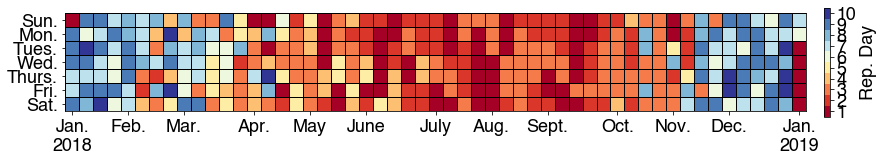

In [423]:
date_heatmap_demo("REPDAYS_ordered")

## Hourly Dispatch

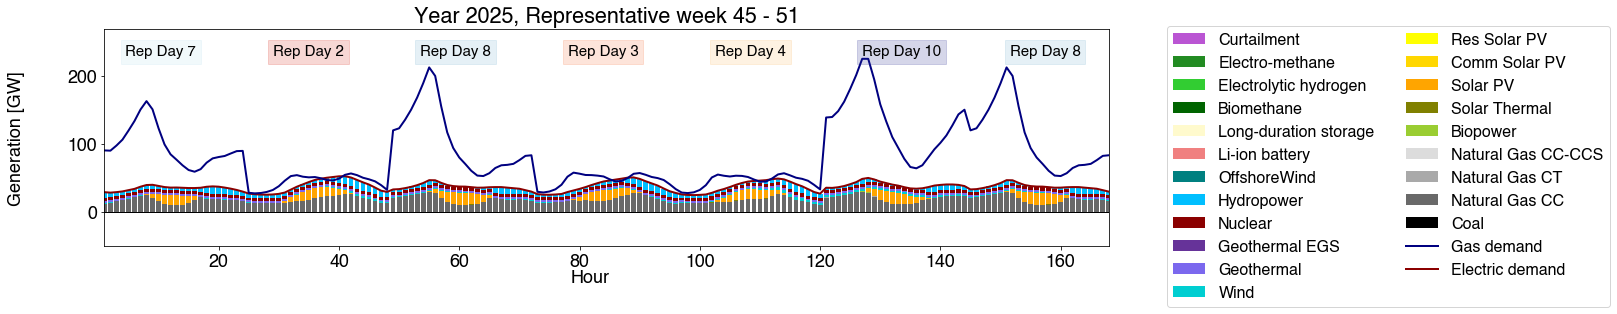

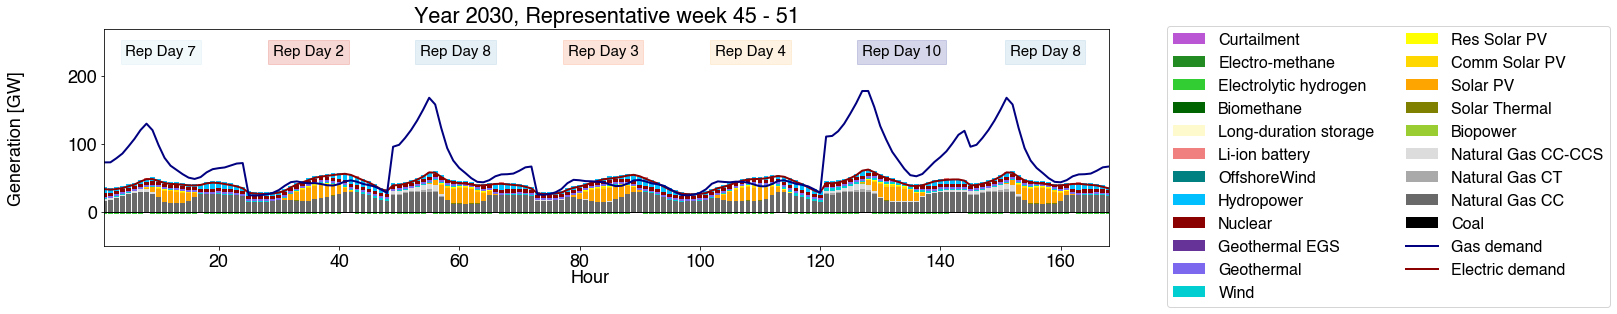

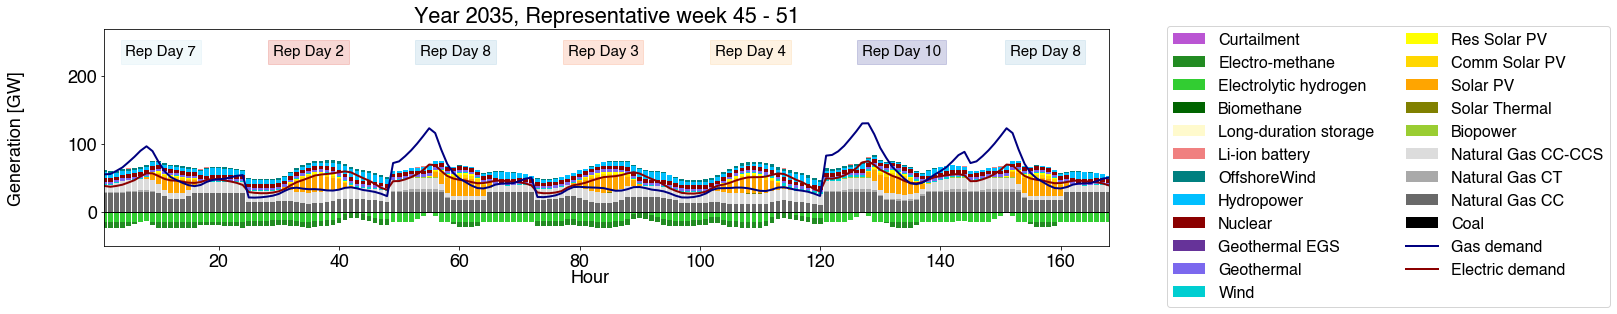

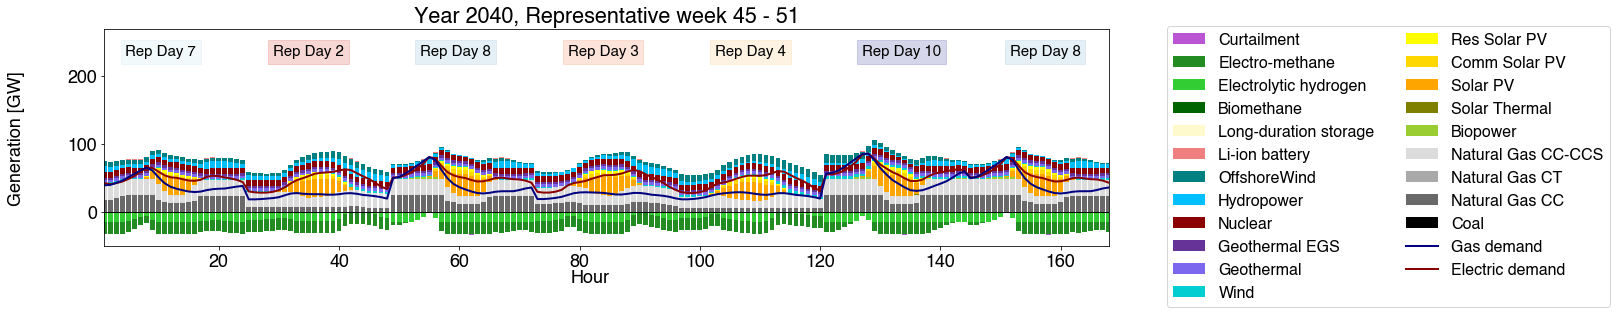

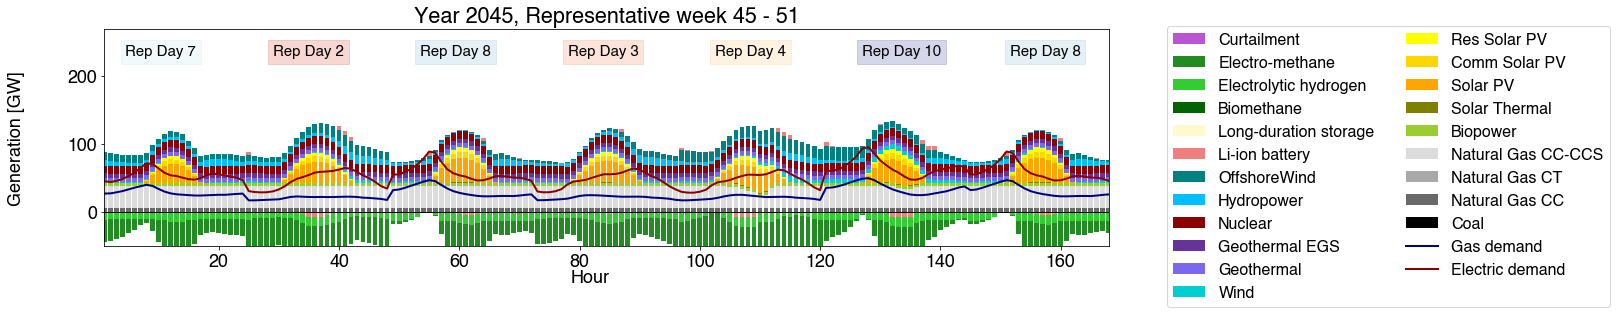

In [424]:
resource_list_hourly = (np.append(np.append(generators["Prime Mover"].to_numpy(), storage_elec["Prime Mover"].to_numpy()), p2g["Prime Mover"].to_numpy()))
resource_list_hourly = np.where(resource_list_hourly == "Net-zero CH4", "Electro-methane",resource_list_hourly)
unique_resources_GEN = generators["Prime Mover"].drop_duplicates().to_numpy()
unique_resources_STORAGE = storage_elec["Prime Mover"].drop_duplicates().to_numpy()
unique_resources_P2G = p2g["Prime Mover"].drop_duplicates().to_numpy()
unique_resources_P2G = np.where(unique_resources_P2G == "Net-zero CH4", "Electro-methane",unique_resources_P2G)
unique_resources_hourly = (np.append(np.append(generators["Prime Mover"].drop_duplicates().to_numpy(), storage_elec["Prime Mover"].drop_duplicates().to_numpy()), p2g["Prime Mover"].drop_duplicates().to_numpy()))
unique_resources_hourly = np.where(unique_resources_hourly == "Net-zero CH4", "Electro-methane",unique_resources_hourly)

repday = pd.read_csv(f"Plots/REPDAYS_ordered.csv").to_numpy()
repday = pd.Series(repday[:,0]).astype(int)

d = 7
nn = -5
iit = 1 # yr for comparison
appliance_cases = np.array([case1])

dataX = pd.read_csv(f"%s/HOURLY_GENERATION.csv" % folder).to_numpy()
data2X = pd.read_csv(f"%s/HOURLY_LOAD.csv" % folder).to_numpy()
        

all_yr = [0,1,2,3,4]
# all_yr = [0]

for yr in all_yr:
    fig, axes = plt.subplots(1, 1, figsize = (18,4), sharex = True, sharey = True)
    for i in range(len(appliance_cases)):
        folder = folder1
        stack = np.zeros((d*24))
        
        if i == 0:
#           cd = int(np.argmax(np.sum(data[0:10,int(yr*8760):int((yr+1)*8760)],0))/24 - 8)
            # cd = int(np.argmin(data[1,int(iit*8760):int((iit+1)*8760)])/24)  - nn
            cd = 44
            
            # cd = 183, 325, 360

        data = dataX[0:-1,int(yr*8760 + (cd)*24):int(yr*8760 + (cd)*24 + d*24)]/1000
        data2 = data2X[:,int(yr*8760 + (cd)*24):int(yr*8760 + (cd)*24 + d*24)]/1000

        for k in range(len(unique_resources_GEN)):
            resources = np.maximum(np.sum(data[resource_list_hourly == unique_resources_GEN[k]],0),0)
            axes.bar(np.linspace(1,d*24,d*24), resources[0:d*24], label = unique_resources_GEN[k],color = colors_GEN[k],  bottom = stack)
            stack = stack + resources[0:d*24]
        stack_plus = stack.copy()
        stack_minus = np.zeros(np.shape(stack))
        for k in range(len(unique_resources_STORAGE)):
            resources_minus = -1*np.maximum(np.sum(data[resource_list_hourly == unique_resources_STORAGE[k]],0),0)
            resources_plus = -1*np.minimum(np.sum(data[resource_list_hourly == unique_resources_STORAGE[k]],0),0)
            axes.bar(np.linspace(1,d*24,d*24), resources_plus[0:d*24], label = unique_resources_STORAGE[k],color = colors_STORAGE[k], bottom = stack_plus)
            axes.bar(np.linspace(1,d*24,d*24), resources_minus[0:d*24],color = colors_STORAGE[k],  bottom = stack_minus)
            stack_plus = stack_plus.copy() + resources_plus[0:d*24]
            stack_minus = stack_minus.copy() + resources_minus[0:d*24]

        for k in range(len(unique_resources_P2G)):
            resources_minus = -1*np.maximum(np.sum(data[resource_list_hourly == unique_resources_P2G[k]],0),0)
            axes.bar(np.linspace(1,d*24,d*24), resources_minus[0:d*24], label = unique_resources_P2G[k], color = colors_P2G[k],bottom = stack_minus)
            stack_minus = stack_minus.copy() + resources_minus[0:d*24]

        axes.bar(np.linspace(1,d*24,d*24), np.minimum((data2[0,0:d*24]-stack_minus)-stack_plus,0), color = "mediumorchid", label = "Curtailment", bottom = stack_minus)

        # axes.plot(np.linspace(1,d*24,d*24), data2[2,0:d*24], label = 'Baseline load', linewidth = 2, color = "firebrick")
        axes.plot(np.linspace(1,d*24,d*24), data2[0,0:d*24], label = 'Electric demand', linewidth = 2, color = 'darkred')
        axes.plot(np.linspace(1,d*24,d*24), data2[1,0:d*24], label = 'Gas demand', linewidth = 2, color = "navy")

        axes.axhline(linewidth=1, color='k')
        axes.set_xlim([1,d*24])
        axes.set_ylim([-50,270])
        axes.set_title(f'Year {2025+yr*5}, Representative week {cd+1} - {cd+1+6}')
        st = 4.5
        dis = 24.5
        cmap = plt.cm.get_cmap('RdYlBu', 10)
        for m in range(7):
            axes.text(st+dis*m, 230, f'Rep Day {repday[cd+m]}', fontsize = 15,bbox = dict(facecolor = cmap(repday[cd+m]-1), alpha = 0.2,edgecolor=cmap(repday[cd+m]-1), pad=5.0))

    handles, labels = axes.get_legend_handles_labels()
    labels = np.where(np.array(labels) == "Electrolysis","Electrolytic hydrogen",np.array(labels))
    axes.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1.05), loc='upper left', prop={'size': 16},ncol=2)
    fig.text(0.5, 0.0, 'Hour', ha='center')
    fig.text(0.05, 0.5, 'Generation [GW]', va='center', rotation='vertical')
    # fig.text(0.005, 0.75, case1, ha='center', va='center', rotation='vertical')
    # fig.savefig(f"Plots/{case_study}/Hourly_Dispatch_{yr+1}_{cd}_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
    plt.show()


## System Cost Breakdown

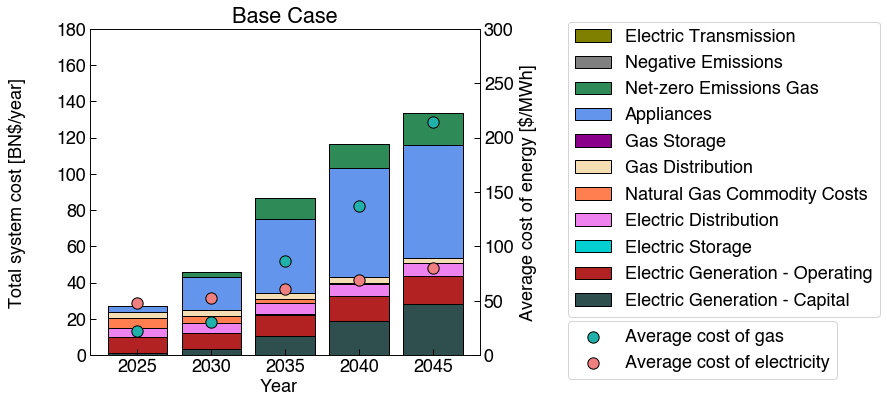

In [468]:
colors_Costs = ["darkslategrey","firebrick","darkturquoise","violet","coral","wheat","darkmagenta","cornflowerblue","seagreen","grey","olive"]
labels_Costs = ["Electric Generation - Capital","Electric Generation - Operating","Electric Storage","Electric Distribution","Natural Gas Commodity Costs","Gas Distribution","Gas Storage","Appliances","Net-zero Emissions Gas","Negative Emissions","Electric Transmission"]

fig, axes = plt.subplots(1, 1, figsize = (7,6), sharex = False, sharey = False)

numm = 0
for i in range(len(appliance_cases)):
    folder = folder1
    data = np.transpose(pd.read_csv(f"%s/EMISSIONS_COSTS.csv" % folder).to_numpy())
    stack = np.zeros((T_inv))
    count = 0
    if numm == 1:
        data[1,0] = (data[1,0] + data[1,1])/2
        data[9,0] = data[9,1]
    for k in range(len(labels_Costs)):
#        if np.sum(data[count+3,:]) > 0:
        if k == 0:
            axes.bar(Years, data[count+3,:]/10**9, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center", edgecolor= 'k')
            stack = stack + data[count+3,:]/10**9        
            count = count+1
        if k == 1:
            axes.bar(Years, (data[count+3,:] + data[count+4,:])/10**9, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center", edgecolor= 'k')
            stack = stack + (data[count+3,:] + data[count+4,:])/10**9                
            count = count+2
        if k > 1:
            axes.bar(Years, data[count+3,:]/10**9, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center", edgecolor= 'k')
            stack = stack + data[count+3,:]/10**9
            count = count+1
        
    axes2 = axes.twinx()
    
    # Scatter for average gas and electricity costs
    axes2.scatter(Years,data[0,:], label = "Average cost of electricity", color = "lightcoral", edgecolors= 'k', s = 128)
    axes2.scatter(Years,data[1,:], label = "Average cost of gas", color = "lightseagreen", edgecolors= 'k' , s = 128)
    # if i < 1:
    #     axes2.set_yticks([])
    # if i >= 1:
    #     axes.set_yticks([])
    axes.tick_params(direction='in', length=6, width=1, colors='k')
    axes2.tick_params(direction='in', length=6, width=1, colors='k')
    axes.axhline(linewidth=1, color='k')
    axes2.axhline(linewidth=1, color='k')

handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.2, 1.05), loc='upper left', prop={'size': 18})
handles, labels = axes2.get_legend_handles_labels()
axes2.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.2, -0.1), loc='lower left', prop={'size': 18})
axes.set_ylim([0,180])
axes2.set_ylim([0,300])
fig.text(-0.02, 0.5, 'Total system cost [BN$/year]', ha='center', va='center', rotation='vertical')
axes.set_title(case1)
axes2.set_ylabel("Average cost of energy [$/MWh]")
fig.text(0.5, 0.04, 'Year', ha='center')
# fig.savefig(f"Plots/{case_study}/Total_Costs_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()

## Locational Capacity Cumulative Build 

<ipython-input-517-cd5531818a46>:37: RuntimeWarning: invalid value encountered in divide
  cum_data = np.cumsum(data_plot[i,:]) / np.cumsum(data_plot[i,:])[-1]


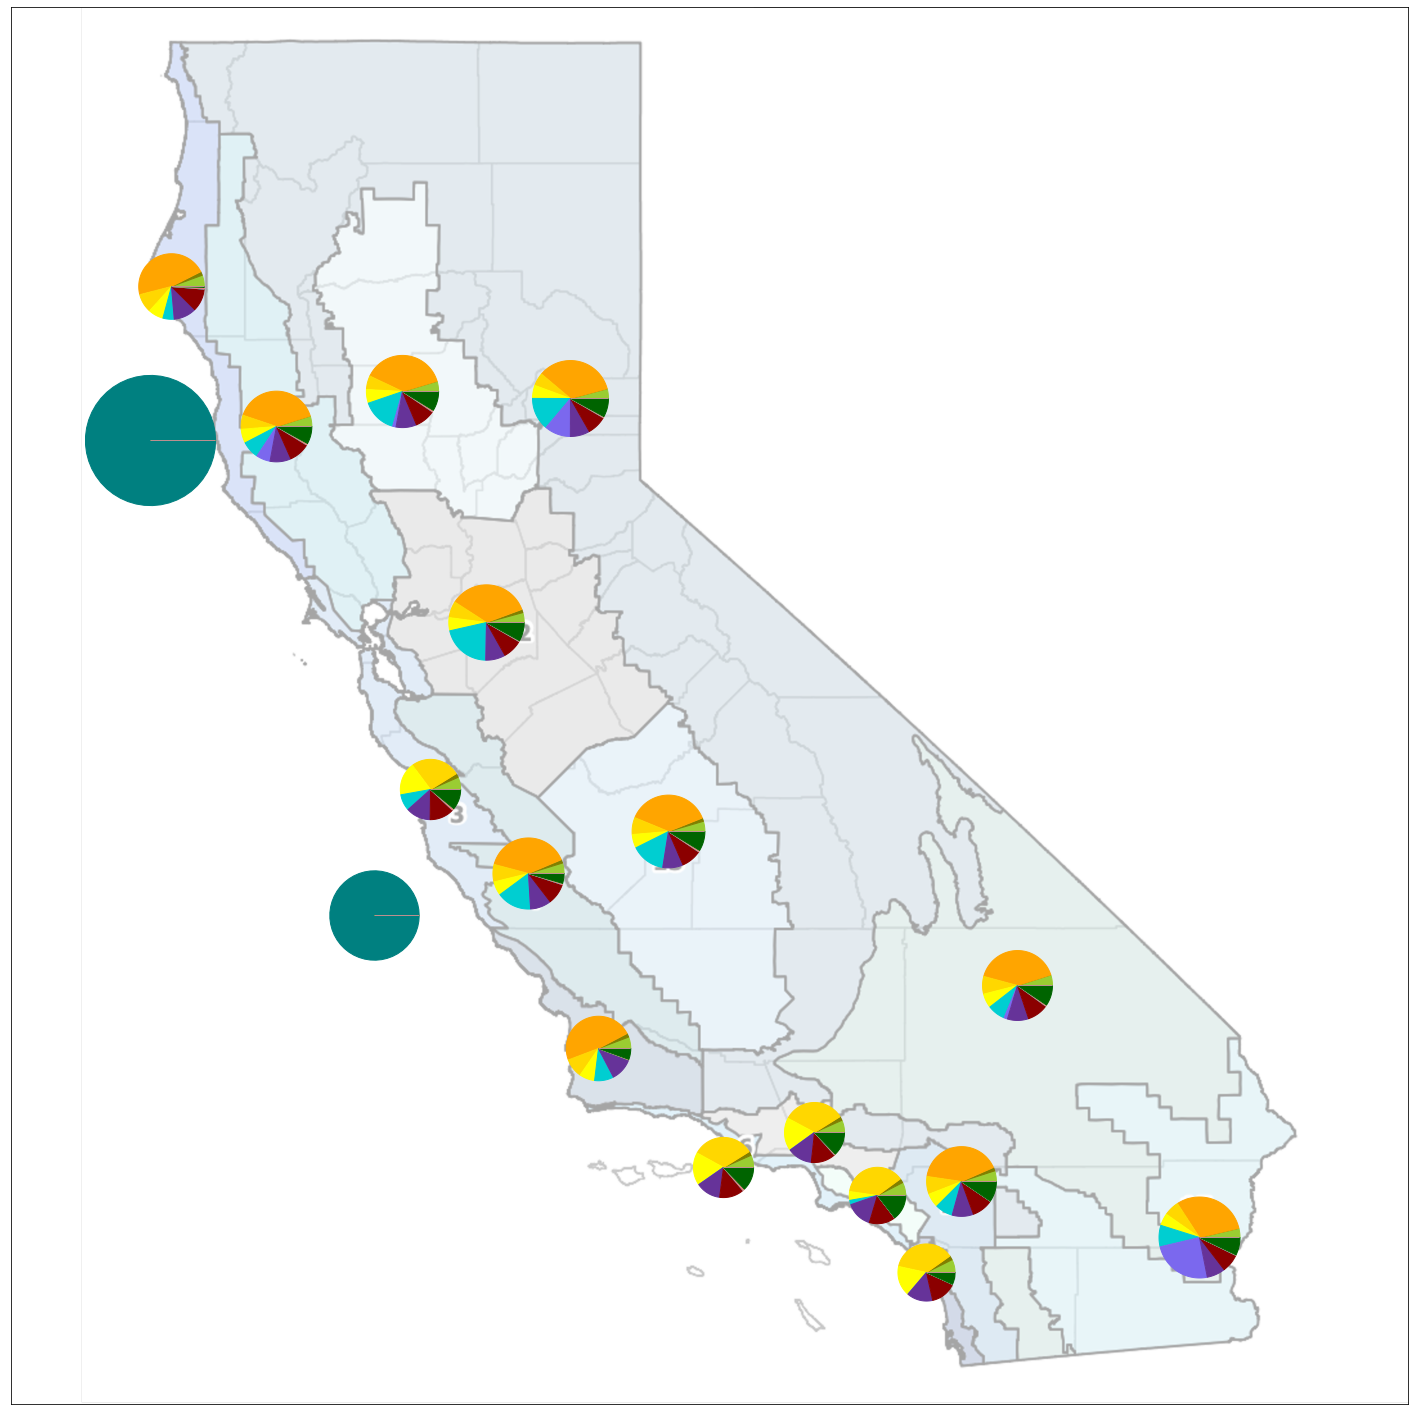

In [517]:
result_yr = 5

fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)
xx = 0

img = plt.imread("Plots/climatezone.png")
axes.imshow(img, extent=[0.5, 10.5, 0, 10])

nodal_locs = np.random.rand(np.max(locational_resources),2)
nodal_locs[:,0] = np.array([1.15,1.9, 3.0 ,  3.7,  4.20, 5.1,  6.55,  6.2, 5.75, 6.8, 2.80, 3.4, 4.7, 7.2, 8.5, 4.0, 2.9 ,4.7,8.5,9,1.0, 2.6])
nodal_locs[:,1] = np.array([8   ,  7, 4.4 ,  3.8,  2.55, 1.7,  0.95,  1.5, 1.95, 1.6, 7.25, 5.6, 4.1, 3.0, 1.2, 7.2, 9.85,7.6,3.8,1.2,6.9, 3.5])

for ii in range(len(appliance_cases)):
    data_plot = np.zeros((np.max(locational_resources),len(unique_resources)))
    data = pd.read_csv(f"%s/CAPACITY_BUILT.csv" % folder).to_numpy()
    data = data[0:-1,:]
    data_retired = pd.read_csv(f"%s/CAPACITY_RETIRED.csv" % folder).to_numpy()
    data_retired = data_retired[0:-1,:]
    stack = np.zeros((T_inv))
    stack_minus = stack.copy()
    for kk in range(np.max(locational_resources)):
        resources = np.zeros((len(unique_resources),T_inv))
        resources_minus = np.zeros((len(unique_resources),T_inv))
        for k in range(len(unique_resources)):
            for j in range(T_inv):
                for jj in range(j+1):
                    resources_minus[k,j] = resources_minus[k,j]+np.sum(data_retired[(resource_list == unique_resources[k]) & (locational_resources == kk+1),jj],0)
                    resources[k,j] = resources[k,j]+np.sum(data[(resource_list == unique_resources[k]) & (locational_resources == kk+1),jj],0)

            data_plot[kk,k] = resources[k,result_yr-1]
            
    sizes = 550*np.random.rand(np.max(locational_resources)) + 250
    sizes = np.sum(data_plot,1)*0.8
    for i in range(len(data_plot[:,0])):
        r = np.zeros((len(data_plot[0,:])+1))
        loc = nodal_locs[i,:]
        cum_data = np.cumsum(data_plot[i,:]) / np.cumsum(data_plot[i,:])[-1]
        cum_data[np.isnan(cum_data)] = 0
        for j in range(len(data_plot[0,:])):
            r[j+1] = cum_data[j]
            x = np.cos(2 * np.pi * np.linspace(r[j], r[j+1]))
            y = np.sin(2 * np.pi * np.linspace(r[j], r[j+1]))
            xy = np.row_stack([[0, 0], np.column_stack([x, y])])
            s1 = np.abs(xy).max()
            axes.scatter(loc[0], loc[1], marker=xy, s=s1**2 * sizes[i], facecolor = colors[j])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xlim([0,10])
    axes.set_ylim([0,10])
    # axes.patch.set_facecolor('white')
    axes.patch.set_alpha(0.7)
# fig.savefig(f"Plots/{case_study}/Locational_Plot_{result_yr}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.tight_layout()


## Locational Generation Mix 

<ipython-input-532-5be89ec9163b>:34: RuntimeWarning: invalid value encountered in divide
  cum_data = np.cumsum(data_plot[i,:]) / np.cumsum(data_plot[i,:])[-1]


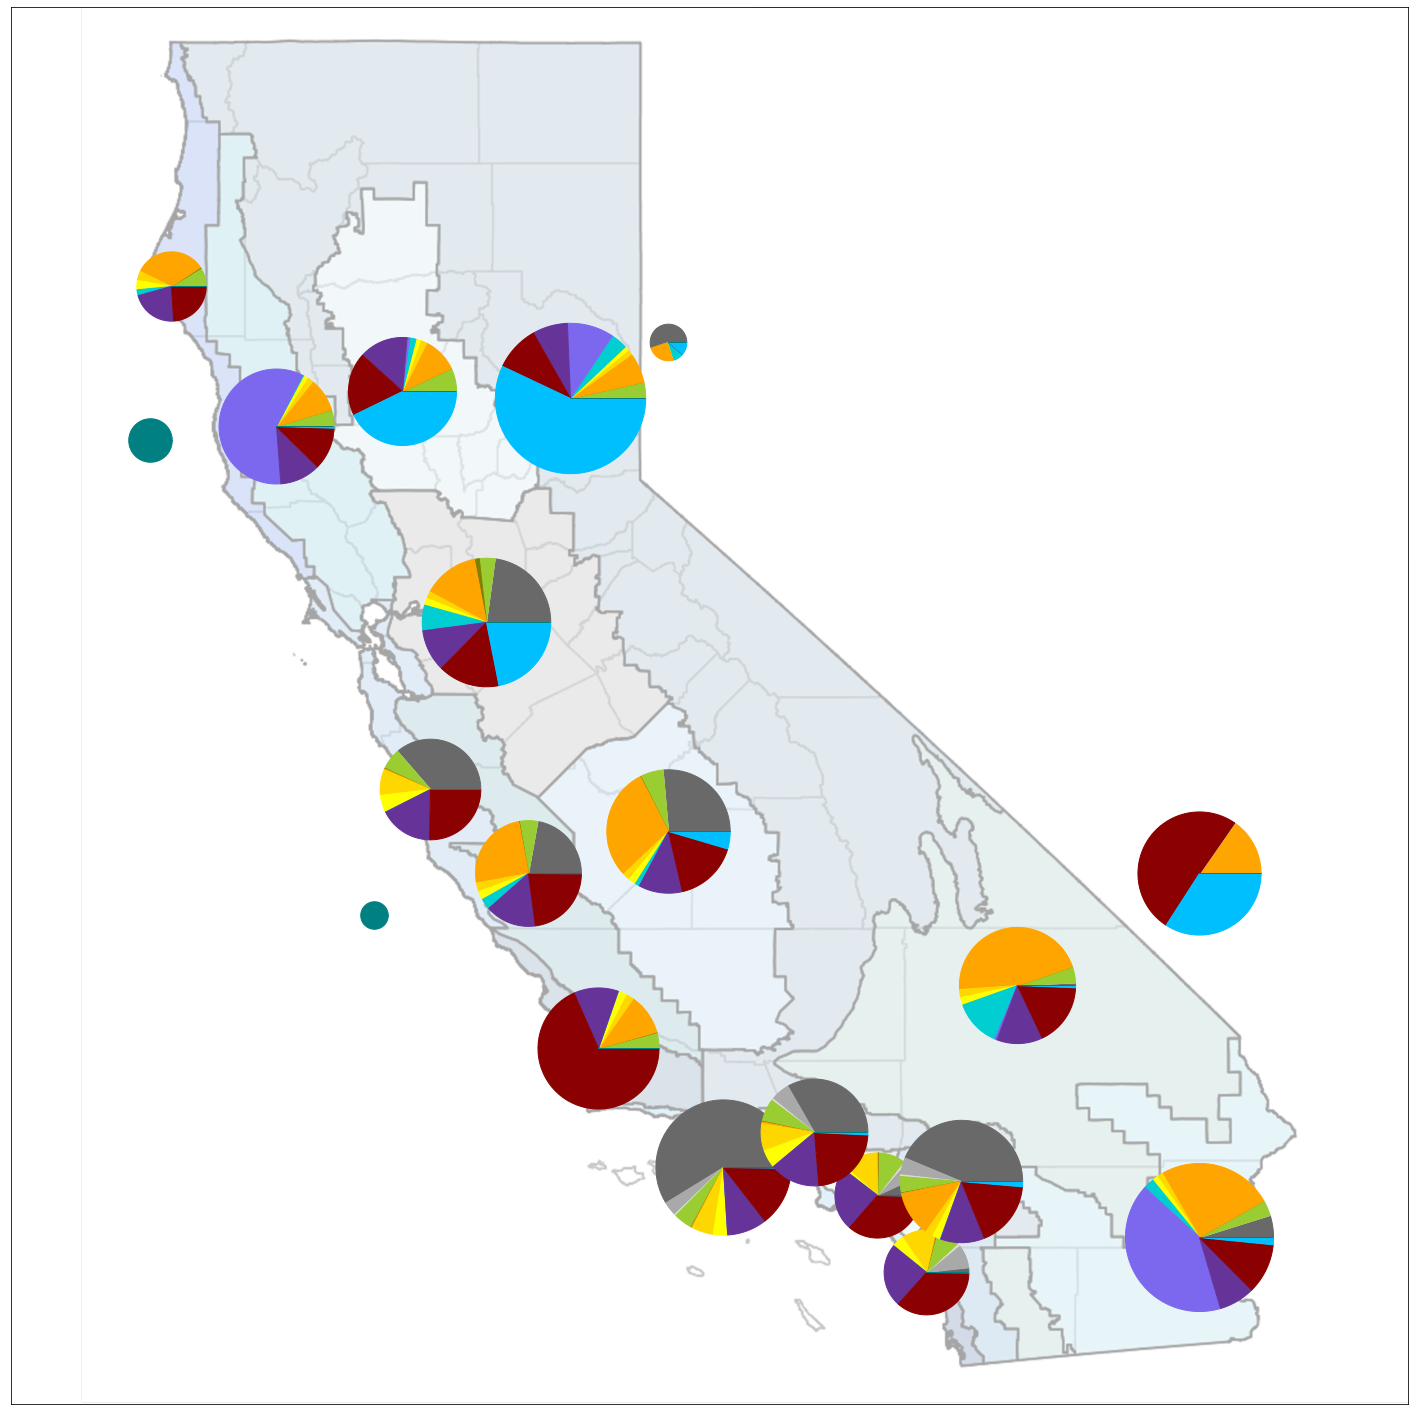

In [532]:
result_yr = 5

fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)
xx = 0

img = plt.imread("Plots/climatezone.png")
axes.imshow(img, extent=[0.5, 10.5, 0, 10])

nodal_locs = np.random.rand(np.max(locational_resources_GEN),2)
nodal_locs[:,0] = np.array([1.15,1.9, 3.0 ,  3.7,  4.20, 5.1,  6.55,  6.2, 5.75, 6.8, 2.80, 3.4, 4.7, 7.2, 8.5, 4.0, 2.9 ,4.7,8.5,9,1.0, 2.6])
nodal_locs[:,1] = np.array([8   ,  7, 4.4 ,  3.8,  2.55, 1.7,  0.95,  1.5, 1.95, 1.6, 7.25, 5.6, 4.1, 3.0, 1.2, 7.2, 9.85,7.6,3.8,1.2,6.9, 3.5])

for ii in range(len(appliance_cases)):
    data_plot = np.zeros((np.max(locational_resources_GEN),len(unique_resources_GEN)))
    data = pd.read_csv(f"%s/GENERATION.csv" % folder).to_numpy()
    data = data[0:-1,:]
    data = data[0:237]
    stack = np.zeros((T_inv))
    stack_minus = stack.copy()
    for kk in range(np.max(locational_resources_GEN)):
        resources = np.zeros((len(unique_resources_GEN),T_inv))
        for k in range(len(unique_resources_GEN)):
            for j in range(T_inv):
                for jj in range(j+1):
                    resources[k,j] = resources[k,j]+np.sum(data[(resource_list_GEN == unique_resources_GEN[k]) & (locational_resources_GEN == kk+1),jj],0)

            data_plot[kk,k] = resources[k,result_yr-1]
            
    sizes = 0.1*np.random.rand(np.max(locational_resources_GEN))
    sizes = np.sum(data_plot,1)*0.0001
    for i in range(len(data_plot[:,0])):
        r = np.zeros((len(data_plot[0,:])+1))
        loc = nodal_locs[i,:]
        cum_data = np.cumsum(data_plot[i,:]) / np.cumsum(data_plot[i,:])[-1]
        cum_data[np.isnan(cum_data)] = 0
        for j in range(len(data_plot[0,:])):
            r[j+1] = cum_data[j]
            x = np.cos(2 * np.pi * np.linspace(r[j], r[j+1]))
            y = np.sin(2 * np.pi * np.linspace(r[j], r[j+1]))
            xy = np.row_stack([[0, 0], np.column_stack([x, y])])
            s1 = np.abs(xy).max()
            axes.scatter(loc[0], loc[1], marker=xy, s=s1**2 * sizes[i], facecolor = colors[j])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xlim([0,10])
    axes.set_ylim([0,10])
    # axes.patch.set_facecolor('white')
    axes.patch.set_alpha(0.7)
# fig.savefig(f"Plots/{case_study}/Locational_Plot_{result_yr}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.tight_layout()


In [181]:
# len(resource_list_GEN)
len(data)

293

## Locational Total Existing Appliance

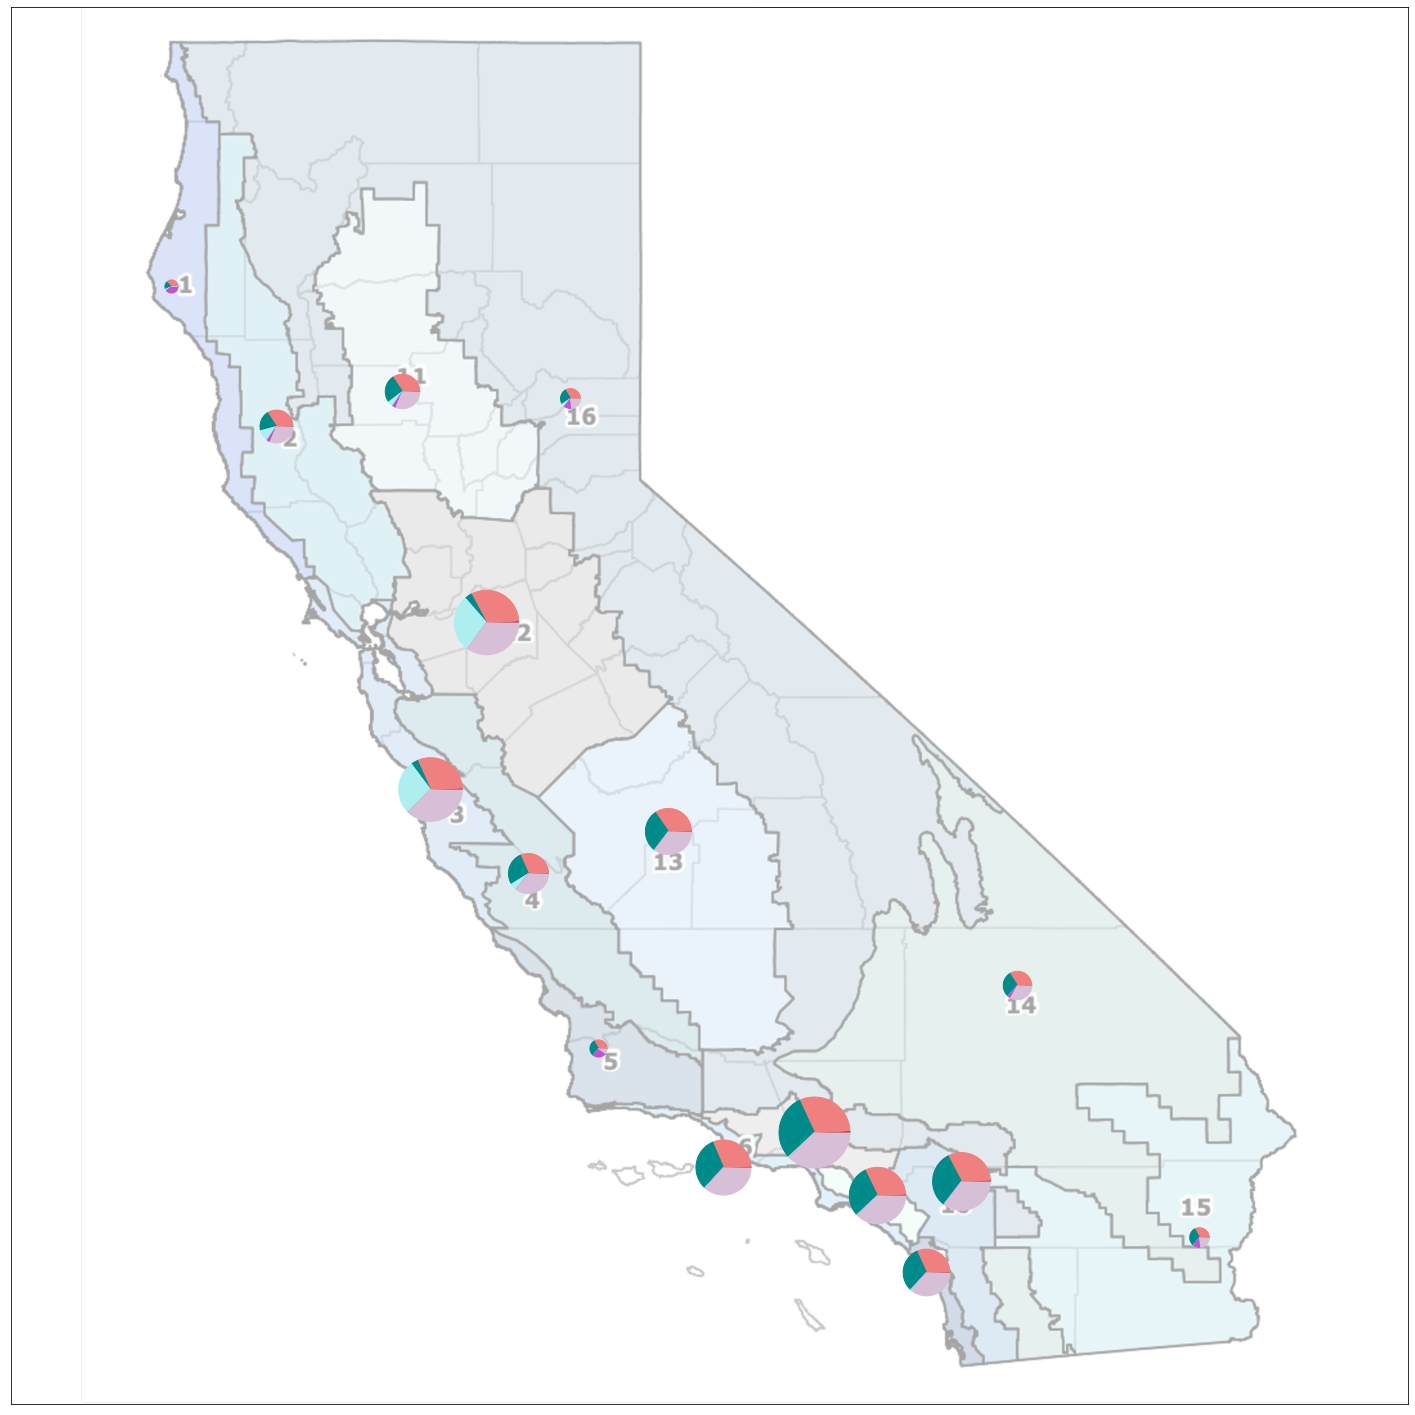

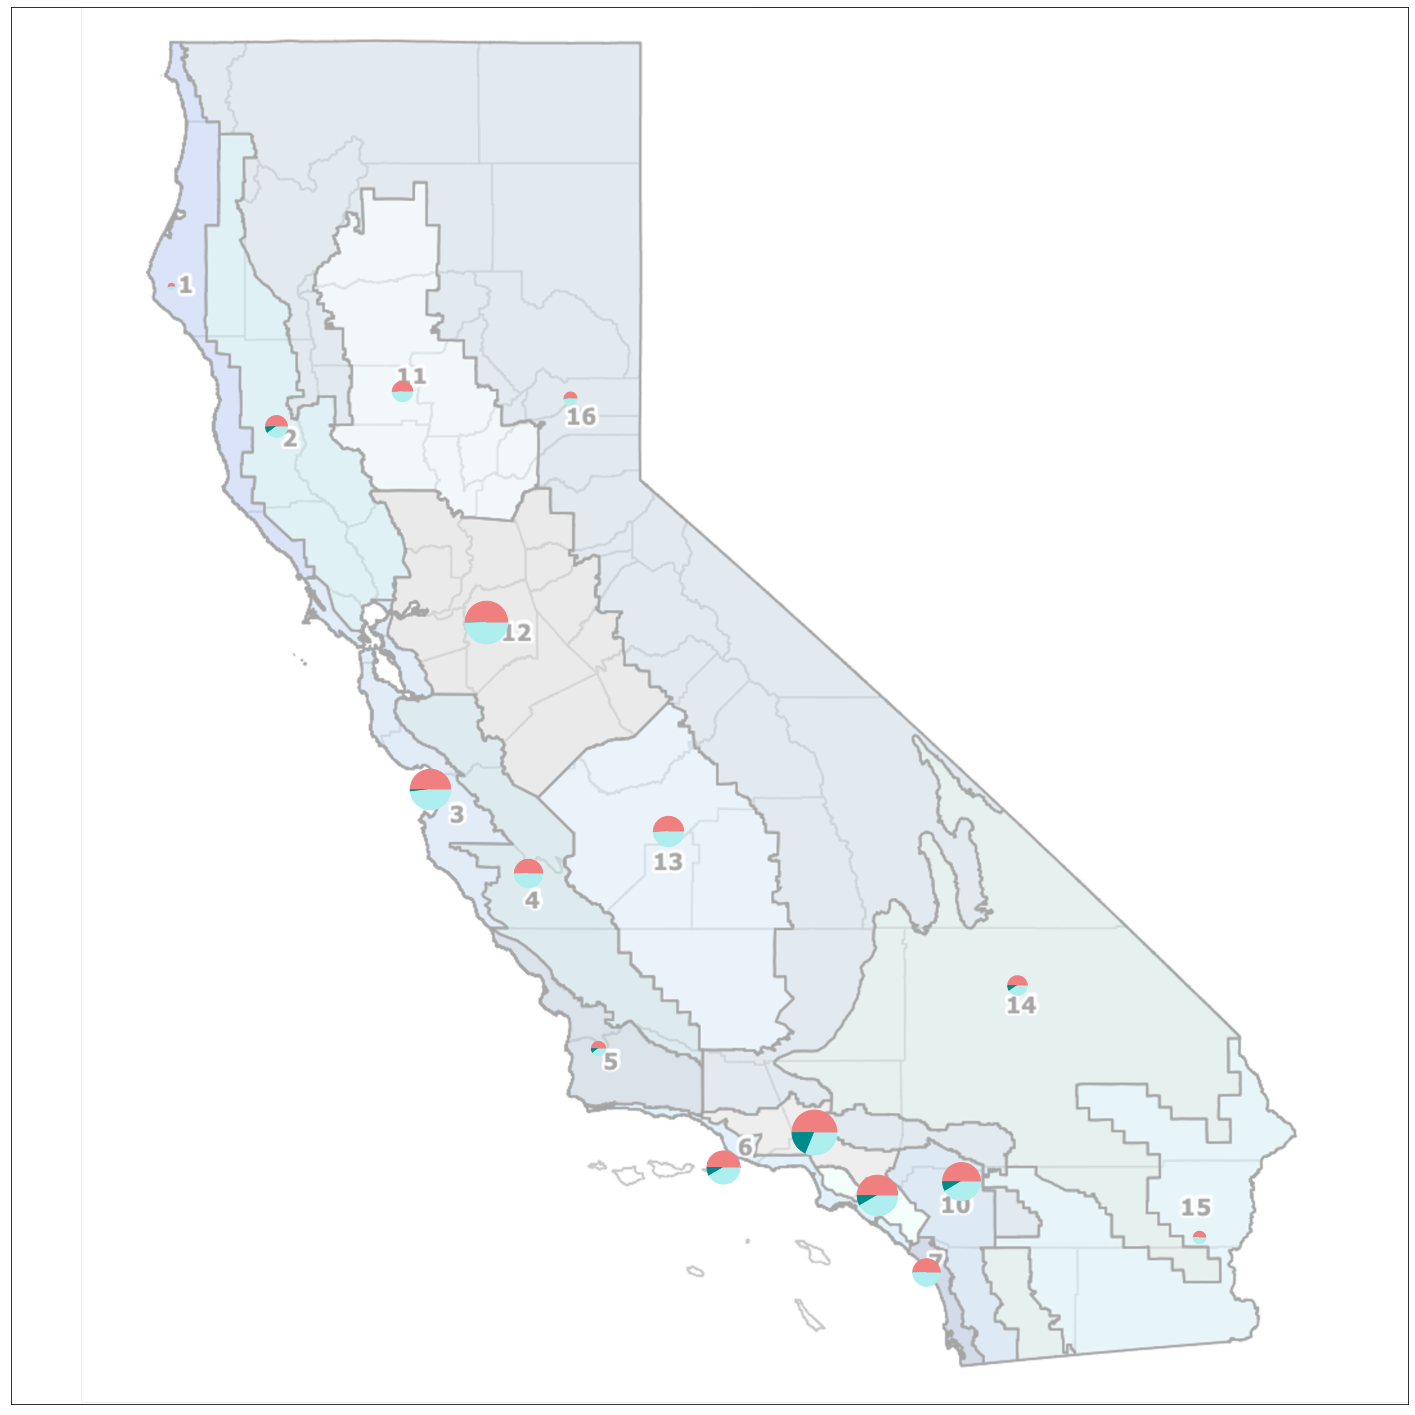

In [519]:
################################################################################################
## Locational Capacity Appliance Total RESIDENTIAL
################################################################################################
result_yr = 6 # 1-5

fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)
xx = 0

img = plt.imread("Plots/climatezone.png")
axes.imshow(img, extent=[0.5, 10.5, 0, 10])

nodal_locs = np.random.rand(np.max(locational_resources),2)
nodal_locs[:,0] = np.array([1.15,1.9, 3.0 ,  3.7,  4.20, 5.1,  6.55,  6.2, 5.75, 6.8, 2.80, 3.4, 4.7, 7.2, 8.5, 4.0, 0,0,8,0,1.0, 2.6])
nodal_locs[:,1] = np.array([8   ,  7, 4.4 ,  3.8,  2.55, 1.7,  0.95,  1.5, 1.95, 1.6, 7.25, 5.6, 4.1, 3.0, 1.2, 7.2, 0,0,4,0,6.9, 3.5])

for ii in range(len(appliance_cases)):
    data_plot = np.zeros((np.max(locational_resources_appliances),len(unique_appliancetypes_RES)))
    data = pd.read_csv(f"%s/APPLIANCE_DECISIONS.csv" % folder).to_numpy()

    newbuild = np.zeros((len(data[:,0]),T_inv))
    premature = np.zeros((len(data[:,0]),T_inv))
    totalpop = np.zeros((len(data[:,0]),T_inv))
    for k in range(T_inv):
        newbuild[:,k] = data[:,k*3]
        premature[:,k] = data[:,k*3+1]
        totalpop[:,k] = data[:,k*3+2]
    newtotalpop = np.zeros((len(data[:,0]),T_inv+1))
    newtotalpop[:,0] = initial_pop
    newtotalpop[:,1:6] = totalpop
    

    data = newtotalpop
    stack = np.zeros((T_inv+1))
    stack_minus = stack.copy()
    for kk in range(np.max(locational_resources_appliances)):
        resources = np.zeros((len(unique_appliancetypes_RES),T_inv+1))
        # resources_minus = np.zeros((len(unique_appliancetypes_RES),T_inv))
        for k in range(len(unique_appliancetypes_RES)):
            for j in range(T_inv+1):
                for jj in range(j+1):
                    # resources_minus[k,j] = resources_minus[k,j]+np.sum(data_retired[(resource_list == unique_resources[k]) & (locational_resources == kk+1),jj],0)
                    resources[k,j] = np.sum(data[(appliances_list == unique_appliancetypes_RES[k]) & (locational_resources_appliances == kk+1),jj],0)

            data_plot[kk,k] = resources[k,result_yr-1]
            
    sizes = np.random.rand(np.max(locational_resources_appliances)) 
    sizes = np.sum(data_plot,1)*1.0
    for i in range(len(data_plot[:,0])):
        r = np.zeros((len(data_plot[0,:])+1))
        loc = nodal_locs[i,:]
        cum_data = np.cumsum(data_plot[i,:])/ np.cumsum(data_plot[i,:])[-1]
        cum_data[np.isnan(cum_data)] = 0
        for j in range(len(data_plot[0,:])):
            r[j+1] = cum_data[j]
            x = np.cos(2 * np.pi * np.linspace(r[j], r[j+1]))
            y = np.sin(2 * np.pi * np.linspace(r[j], r[j+1]))
            xy = np.row_stack([[0, 0], np.column_stack([x, y])])
            s1 = np.abs(xy).max()
            axes.scatter(loc[0], loc[1], marker=xy, s=s1**2 * sizes[i], facecolor = colors_ResApps[j])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xlim([0,10])
    axes.set_ylim([0,10])
    # axes.patch.set_facecolor('white')
    axes.patch.set_alpha(0.7)
# fig.savefig(f"Plots/{case_study}/Locational_Plot_AppliancesTotal_{result_yr}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.tight_layout()

################################################################################################
## Locational Capacity Appliance Total COMMERCIAL
################################################################################################
result_yr = 6 # 1-5

fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)
xx = 0

img = plt.imread("Plots/climatezone.png")
axes.imshow(img, extent=[0.5, 10.5, 0, 10])

nodal_locs = np.random.rand(np.max(locational_resources),2)
nodal_locs[:,0] = np.array([1.15,1.9, 3.0 ,  3.7,  4.20, 5.1,  6.55,  6.2, 5.75, 6.8, 2.80, 3.4, 4.7, 7.2, 8.5, 4.0, 0,0,8,0,1.0, 2.6])
nodal_locs[:,1] = np.array([8   ,  7, 4.4 ,  3.8,  2.55, 1.7,  0.95,  1.5, 1.95, 1.6, 7.25, 5.6, 4.1, 3.0, 1.2, 7.2, 0,0,4,0,6.9, 3.5])

for ii in range(len(appliance_cases)):
    data_plot = np.zeros((np.max(locational_resources_appliances),len(unique_appliancetypes_COMM)))
    data = pd.read_csv(f"%s/APPLIANCE_DECISIONS.csv" % folder).to_numpy()

    newbuild = np.zeros((len(data[:,0]),T_inv))
    premature = np.zeros((len(data[:,0]),T_inv))
    totalpop = np.zeros((len(data[:,0]),T_inv))
    for k in range(T_inv):
        newbuild[:,k] = data[:,k*3]
        premature[:,k] = data[:,k*3+1]
        totalpop[:,k] = data[:,k*3+2]
    newtotalpop = np.zeros((len(data[:,0]),T_inv+1))
    newtotalpop[:,0] = initial_pop
    newtotalpop[:,1:6] = totalpop
    

    data = newtotalpop
    stack = np.zeros((T_inv+1))
    stack_minus = stack.copy()
    for kk in range(np.max(locational_resources_appliances)):
        resources = np.zeros((len(unique_appliancetypes_COMM),T_inv+1))
        # resources_minus = np.zeros((len(unique_appliancetypes_RES),T_inv))
        for k in range(len(unique_appliancetypes_COMM)):
            for j in range(T_inv+1):
                for jj in range(j+1):
                    # resources_minus[k,j] = resources_minus[k,j]+np.sum(data_retired[(resource_list == unique_resources[k]) & (locational_resources == kk+1),jj],0)
                    resources[k,j] = np.sum(data[(appliances_list == unique_appliancetypes_COMM[k]) & (locational_resources_appliances == kk+1),jj],0)

            data_plot[kk,k] = resources[k,result_yr-1]
            
    sizes = np.random.rand(np.max(locational_resources_appliances)) 
    sizes = np.sum(data_plot,1)*40
    for i in range(len(data_plot[:,0])):
        r = np.zeros((len(data_plot[0,:])+1))
        loc = nodal_locs[i,:]
        cum_data = np.cumsum(data_plot[i,:])/ np.cumsum(data_plot[i,:])[-1]
        cum_data[np.isnan(cum_data)] = 0
        for j in range(len(data_plot[0,:])):
            r[j+1] = cum_data[j]
            x = np.cos(2 * np.pi * np.linspace(r[j], r[j+1]))
            y = np.sin(2 * np.pi * np.linspace(r[j], r[j+1]))
            xy = np.row_stack([[0, 0], np.column_stack([x, y])])
            s1 = np.abs(xy).max()
            axes.scatter(loc[0], loc[1], marker=xy, s=s1**2 * sizes[i], facecolor = colors_CommApps[j])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xlim([0,10])
    axes.set_ylim([0,10])
    # axes.patch.set_facecolor('white')
    axes.patch.set_alpha(0.7)
# fig.savefig(f"Plots/{case_study}/Locational_Plot_AppliancesTotal_{result_yr}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.tight_layout()



## Locational Total Appliance Consumption

## Gas and Electricity Flow Between Regions

In [66]:
def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

[-4.87595436e+02 -9.25062813e+02  2.34398026e-04  6.59999989e+02
  7.28999987e+02 -4.66950476e+02 -1.00361957e+03  1.15499998e+03
  2.59414537e+02  5.12999990e+02  3.47115514e+02  2.71329728e+02
  6.85532691e+02 -1.75430343e+02  8.11093242e+02  6.56998833e+02
 -1.03799984e+03  9.05999992e+02 -7.94999853e+02 -1.23980265e+03
 -7.59977174e+02 -1.09895471e+03 -2.24303031e+03 -1.31319630e+03
 -7.73758699e+02 -1.41599978e+03 -1.55699978e+03  0.00000000e+00
 -8.75999785e+02 -1.55699959e+03 -9.44999854e+02  4.15998189e+02
  2.03721198e+02]


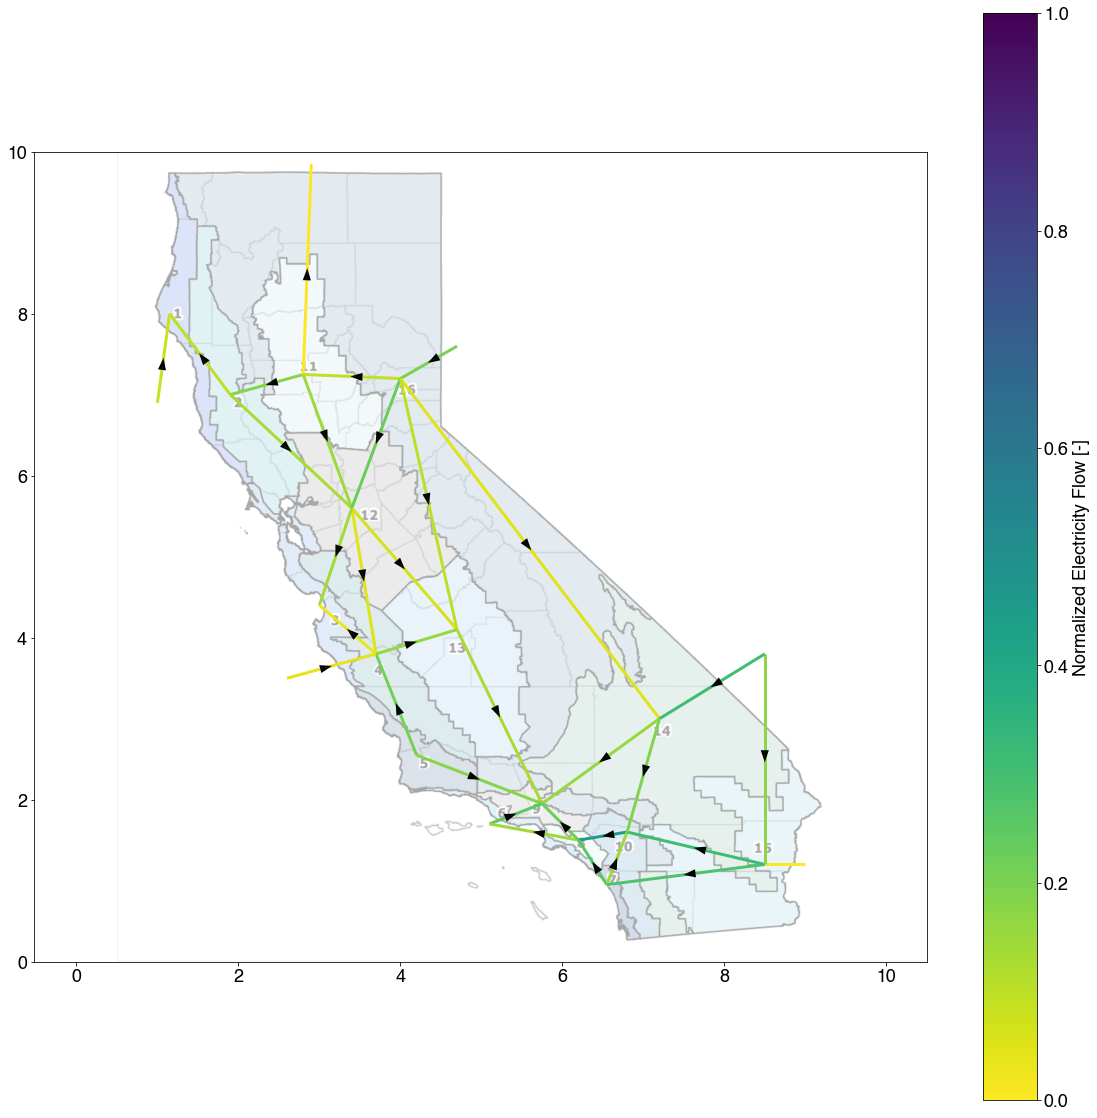

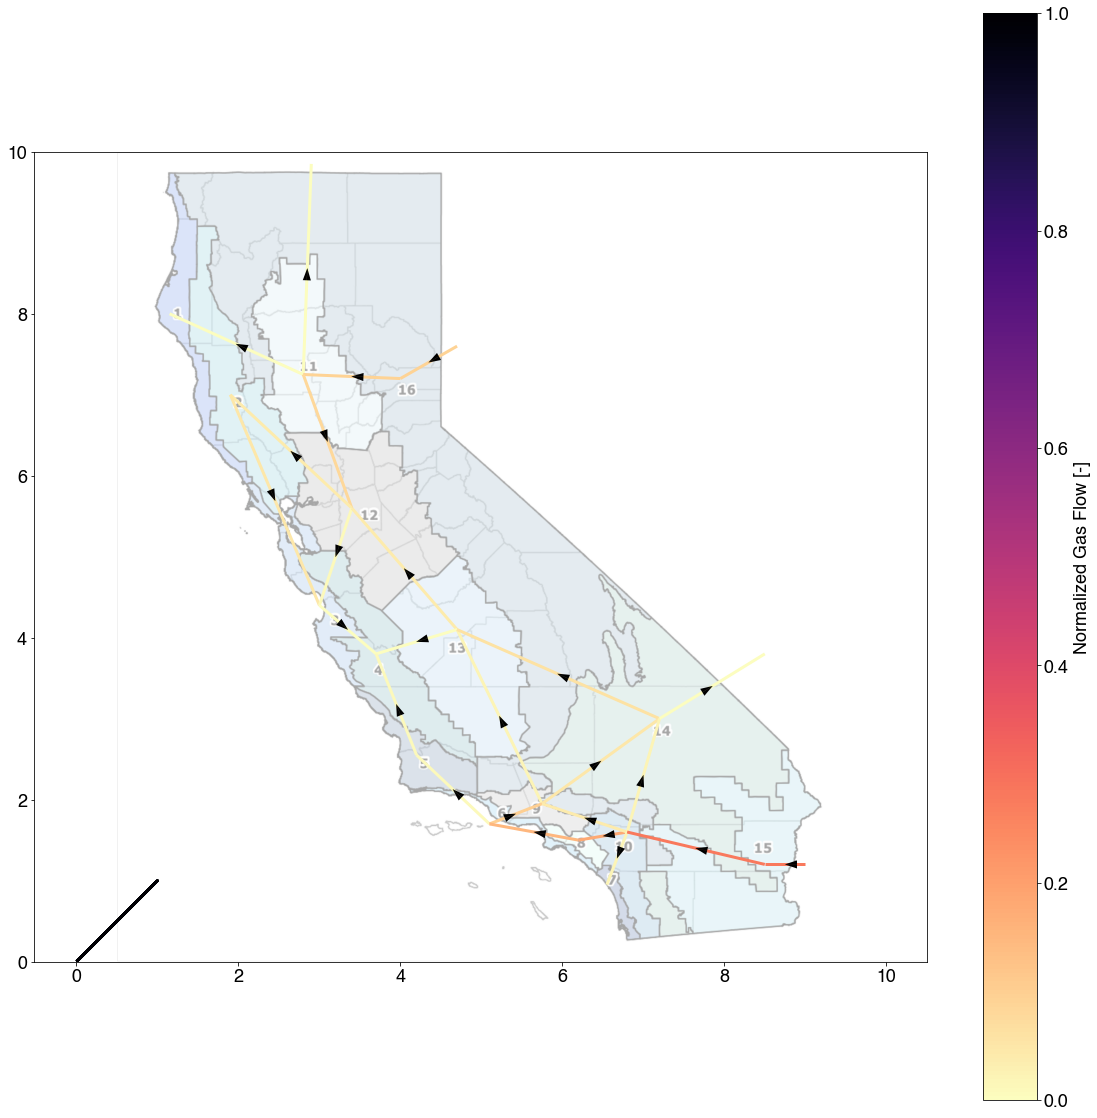

In [75]:
################################################################################################
## Flow gas and electricity
################################################################################################
from numpy import linalg as LA
fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)

img = plt.imread("Plots/climatezone.png")
axes.imshow(img, extent=[0.5, 10.5, 0, 10])

nodal_locs = np.random.rand(np.max(locational_resources),2)
nodal_locs[:,0] = np.array([1.15,1.9, 3.0 ,  3.7,  4.20, 5.1,  6.55,  6.2, 5.75, 6.8, 2.80, 3.4, 4.7, 7.2, 8.5, 4.0, 2.9 ,4.7,8.5,9,1.0, 2.6])
nodal_locs[:,1] = np.array([8   ,  7, 4.4 ,  3.8,  2.55, 1.7,  0.95,  1.5, 1.95, 1.6, 7.25, 5.6, 4.1, 3.0, 1.2, 7.2, 9.85,7.6,3.8,1.2,6.9, 3.5])

# data_gas (row = edge, col = days for yrs 1-5)
# data_elec (row = edge, col = hours in day, days for yrs 1-5)
data_gas = pd.read_csv(f"%s/DAILY_GAS_TRANSMISSION.csv" % folder).to_numpy()
data_elec = pd.read_csv(f"%s/HOURLY_ELECTRIC_TRANSMISSION.csv" % folder).to_numpy()
elec_network = pd.read_csv("Data/ElecTransmissionNetwork.csv")
nodein_elec = elec_network["Node In"]
nodeout_elec = elec_network["Node Out"]
gas_network = pd.read_csv("Data/GasTransmissionNetwork.csv")
nodein_gas = gas_network["Node In"]
nodeout_gas = gas_network["Node Out"]

yr = 4
cd = 2
d = 1 # no changing this!
hr = 17
max_gas = np.amax(abs(data_gas))
max_elec = np.amax(abs(data_elec))
day_gas = data_gas[:,int(yr*365 + (cd-1)):int(yr*365 + (cd-1) + d)]
day_elec = data_elec[:,int(yr*8760 + (cd-1)*24):int(yr*8760 + (cd-1)*24 + d*24)]
print(day_elec[:,hr])

elec_flow = np.linspace(1., 4., len(nodein_elec)+1)
linex = np.eye(len(nodein_elec)+1, 100)
liney = np.eye(len(nodein_elec)+1, 100)

for i in range(len(nodein_elec)):
    nodeoutx = nodal_locs[nodeout_elec[i]-1,0]
    nodeouty = nodal_locs[nodeout_elec[i]-1,1]
    nodeinx = nodal_locs[nodein_elec[i]-1,0]
    nodeiny = nodal_locs[nodein_elec[i]-1,1]
    linex[i,:] = np.linspace(nodeoutx,nodeinx,100)
    liney[i,:] = np.linspace(nodeouty,nodeiny,100)

    elec_flow[i] = np.round(abs(day_elec[i,hr])/max_elec,2)
    
linex[len(nodein_elec),:] = np.linspace(0,0,1)
liney[len(nodein_elec),:] = np.linspace(0,0,1)
elec_flow[len(nodein_elec)] = 1

lc = multiline(linex, liney, elec_flow, cmap='viridis_r', lw=3) #viridis_r
for i in range(len(nodein_elec)):
    plt.arrow(linex[i,50], liney[i,50], np.sign(day_elec[i,hr])*(linex[i,50]-linex[i,51]), np.sign(day_elec[i,hr])*(liney[i,50]-liney[i,51]), shape='full', lw=0, length_includes_head=True, head_width=.1,color = "black",zorder=10)
axcb = fig.colorbar(lc)
axcb.set_label('Normalized Electricity Flow [-]')
# fig.savefig(f"Plots/{case_study}/Flow_Elec_{yr+1}_{cd}_{hr}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.show()

fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)

img = plt.imread("Plots/climatezone.png")
axes.imshow(img, extent=[0.5, 10.5, 0, 10])

gas_flow = np.linspace(1., 4., len(nodein_gas)-2+1)
linexgas = np.eye(len(nodein_gas)-2+1, 100)
lineygas = np.eye(len(nodein_gas)-2+1, 100)

for i in range(len(nodein_gas)-2):
    nodeoutxgas = nodal_locs[nodeout_gas[i]-1,0]
    nodeoutygas = nodal_locs[nodeout_gas[i]-1,1]
    nodeinxgas = nodal_locs[nodein_gas[i]-1,0]
    nodeinygas = nodal_locs[nodein_gas[i]-1,1]
    linexgas[i,:] = np.linspace(nodeoutxgas,nodeinxgas,100)
    lineygas[i,:] = np.linspace(nodeoutygas,nodeinygas,100)

    gas_flow[i] = np.round(abs(day_gas[i])/max_gas,2)
linex[len(nodein_gas),:] = np.linspace(0,0,1)
liney[len(nodein_gas),:] = np.linspace(0,0,1)
gas_flow[len(nodein_gas)-2] = 1

lc = multiline(linexgas, lineygas, gas_flow, cmap='magma_r', lw=3)
for i in range(len(nodein_gas)-2):
    plt.arrow(linexgas[i,50], lineygas[i,50], linexgas[i,50]-linexgas[i,51], lineygas[i,50]-lineygas[i,51], shape='full', lw=0, length_includes_head=True, head_width=.1,color = "black",zorder=10)
axcb = fig.colorbar(lc)
axcb.set_label('Normalized Gas Flow [-]')
# fig.savefig(f"Plots/{case_study}/Flow_Gas_{yr+1}_{cd}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.show()



## Gas SOC and Slack Supply

In [67]:
gas_storedenergy = pd.read_csv(f"%s/HOURLY_GAS_STOREDENERGY.csv" % folder).to_numpy()
gas_soc = pd.read_csv(f"%s/DAILY_GAS_SOC.csv" % folder).to_numpy()
elec_storedenergy = pd.read_csv(f"%s/HOURLY_ELEC_STOREDENERGY.csv" % folder).to_numpy()


In [65]:
# np.sum(gas_soc[15,0:365])+np.sum(gas_soc[14,0:365])
np.sum(gas_soc[15,365:365*2])+np.sum(gas_soc[14,365:365*2])

33605189.63759462

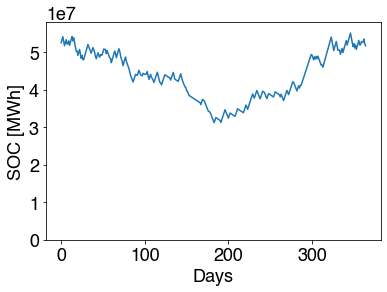

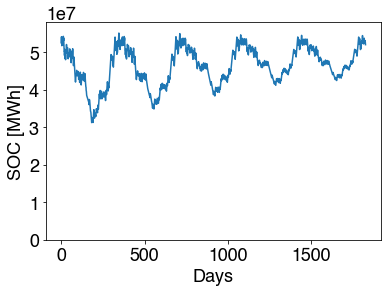

In [69]:
# each row = each underground storage site except las row is slack gas
# each column hourly state of charge 24 hr, 365 days, 5 inv period
            
plt.plot(sum(gas_soc[:14,365*0:365*1],0))
plt.ylabel("SOC [MWh]")
plt.xlabel("Days")
plt.ylim(0,5.8e7)
plt.show()

plt.plot(sum(gas_soc[:14,:],0))
plt.ylabel("SOC [MWh]")
plt.xlabel("Days")
plt.ylim(0,5.8e7)
plt.show()

# plt.plot(gas_soc[15,:])
# plt.ylabel("SOC [MWh]")
# plt.xlabel("Hours")
# # plt.ylim(0,20000)
# plt.show()

# plt.plot(gas_soc[14,:])
# plt.ylabel("SOC [MWh]")
# plt.xlabel("Hours")
# # plt.ylim(0,20000)
# plt.show()
